In [397]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [398]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 

from lib.xedt import XEDT, Loss

In [399]:
if 'experiment_name' not in globals():
    from evclust.ecm import ecm

    folder_figs = None

    df = pd.read_csv('data/three_clusters2D_synth.csv')
    feature_names = df.columns[:-1].to_list()
    features = df.iloc[:, :-1].values

    number_clusters = 3
    full_model = ecm(x=features, c=number_clusters, alpha=0.5, beta = 1.8, delta=10, disp=False, type='full')
    simple_model = ecm(x=features, c=number_clusters, alpha=0.5, beta = 1.8, delta=10, disp=False, type='simple')
    rough_model = ecm(x=features, c=number_clusters, alpha=1, beta = 1.01, delta=10, disp=False, type='full')

    # model_names : (mass, F, lambda_num)
    masses_to_test = {
        'full': (full_model['mass_n'], full_model['F'][1:], 1),
        # 'simple': (simple_model['mass_n'], simple_model['F'][1:], 0.5),
        # 'rough': (rough_model['mass_n'], rough_model['F'][1:], 1)
    }
features_dimension = features.shape[1]
if features_dimension == 2:
    features_labels = ['x','y']
else:
    features_labels = [f'x_{i}' for i in range(features_dimension)]

if 'cmap' not in globals():
    cmap = 'Set1'

/Users/victor/Documents/GitHub/iemm/.venv/lib/python3.9/site-packages/evclust/ecm.py:150: RuntimeWarning: overflow encountered in power
  vect1 = (np.tile(D[i, j], f-1) / vect0) ** (1 / (beta-1))
/Users/victor/Documents/GitHub/iemm/.venv/lib/python3.9/site-packages/evclust/ecm.py:152: RuntimeWarning: overflow encountered in multiply
  vect3 = vect1 * vect2


In [400]:
def get_style(F, cmap):    
    number_metaclusters = len(F)
    number_clusters = len(F[0])
    cmap = plt.get_cmap(cmap)
    
    if number_clusters == 3 and cmap.name == 'Pastel1':
        cluster_base_colors = [np.array(cmap(1)), np.array(cmap(2)), np.array(cmap(0))]
        cardinality_indication_color = np.array(cmap(7))
        cardinality_indication_color = np.array([1, 1, 1, 1])
    if number_clusters == 3 and cmap.name == 'Set1':
        cluster_base_colors = [np.array(cmap(1)), np.array(cmap(2)), np.array(cmap(4))]
        cardinality_indication_color = np.array(cmap(7))
        cardinality_indication_color = np.array([0.9, 0.9, 0.9, 1])
    else:
        cluster_base_colors = [np.array(cmap(i)) for i in range(len(F))]
        cardinality_indication_color = np.array(cmap(number_metaclusters))
    focal_colors = []

    for f in F:
        color = np.array([0., 0., 0., 0.])
        for i in range(len(f)):
            if f[i] == 1:
                color += cluster_base_colors[i]
        color = color/np.sum(f)

        color = color + (cardinality_indication_color - color) * (np.sum(f)-1)/(number_clusters-1)

        focal_colors.append(color)
    focal_colors[0] = cluster_base_colors[0]
    
    # formatting focal sets for printing
    focal_sets = [" \\cup ".join(["\\omega_{" + str(i+1) + "}" for i in range(len(f)) if f[i] == 1]) for f in F]
    mass_focal_sets = ['$m_{'+focal_sets[i]+'}$' for i in range(number_clusters)]
    focal_sets = ['$'+f+'$' for f in focal_sets]

    return focal_colors, focal_sets, mass_focal_sets

In [401]:
def get_centroids(F, masses):
    """
    Compute the centroids of the clusters based on the focal sets and their masses.
    """
    metacluster_centroids = []
    for i in range(len(F)):
        if np.sum(F[i]) > 0:
            centroid = np.zeros(features.shape[1])
            for point in range(features.shape[0]):
                centroid += features[point] * masses[point, i]
            centroid /= np.sum(masses[:, i])
            metacluster_centroids.append(centroid)
    metacluster_centroids = np.array(metacluster_centroids)

    return metacluster_centroids

In [402]:
def get_colors(focal_colors, masses):    
    colors = []
    for point in range(len(features)):
        color = np.sum([focal_colors[i] * masses[point, i] for i in range(len(focal_colors))], axis=0)
        color = np.clip(color, 0, 1)
        color = color[:3]
        colors.append(color)

    return colors

In [ ]:
def explore_iemm(mass, F, model_name, lambdas, ax=None):
    # getting the colorscheme and focal sets names
    focal_colors, focal_sets, mass_focal_sets = get_style(F, cmap=cmap)

    diagram_args = {
        'class_names' : mass_focal_sets,
        'cluster_names' : focal_sets,
        'feature_names' : feature_names,
    }
    
    if not ax is None:
        diagram_args['focal_colors'] = focal_colors

        # getting centroids
        metacluster_centroids = get_centroids(F, mass)

        # getting each point color
        colors = get_colors(focal_colors, mass)

        # plotting points
        ax[0].set_title(f"$\mathcal{{M}}_{{{model_name}}}$")
        for i in range(len(features)):
            ax[0].scatter(features[i, 0], features[i, 1], color=colors[i], edgecolor='black', linewidth=0.5)
        # informing the legend
        for i in range(len(focal_sets)):
            ax[0].scatter([], [], color=focal_colors[i], label=focal_sets[i])
        # plot centroids
        for i in range(len(metacluster_centroids)):
            ax[0].scatter(metacluster_centroids[i, 0], metacluster_centroids[i, 1], color=focal_colors[i], edgecolor='black', marker='*', s=200)
        # remove ticks
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        # get the limits
        xmin, xmax = ax[0].get_xlim()
        ymin, ymax = ax[0].get_ylim()

    diagrams, paths, pred_metaclusters = {}, {}, {}
    idx_img = 0
    for lambda_mistakeness in lambdas:
        # goes to next plot
        idx_img += 1

        # getting the IEMM classifier
        classifier = XEDT(lambda_mistakeness=lambda_mistakeness)

        y = mass.copy()
        classifier.fit(features, y, F)
        diagram = classifier.plot_tree(
            **diagram_args
        )
        diagrams[lambda_mistakeness] = diagram

        pred_metaclusters[lambda_mistakeness] = classifier.predict_metacluster(features).reshape(-1)

        # getting the path (that is, the explanation) for each metacluster
        path = classifier.get_path(features_labels, focal_sets)
        paths[lambda_mistakeness] = path
        # saving the diagram
        if folder_figs is not None:
            os.makedirs(f'{folder_figs}/{model_name}', exist_ok=True)
            diagram.save(f'{folder_figs}/{model_name}/diagram_{lambda_mistakeness}.pdf')

        if not ax is None:
            # plotting the regions
            X, Y = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
            features_xy = np.column_stack((X.ravel(), Y.ravel()))
            Z_metclus = classifier.predict_metacluster(features_xy).reshape(X.shape[0], X.shape[1], -1)
            Z_color = np.zeros((X.shape[0], X.shape[1], 3))
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    Z_color[i, j] = focal_colors[Z_metclus[i, j, 0]][:3]
            ax[idx_img].imshow(Z_color, extent=(xmin, xmax, ymin, ymax), origin='lower', aspect='auto')

            # defining the title
            if lambda_mistakeness == np.inf:
                title = f'$M^\infty_{{\mathcal{{M}}_{{{model_name}}}}}$'
            else:
                title = f'$M^{{{lambda_mistakeness}}}_{{\mathcal{{M}}_{{{model_name}}}}}$'
            ax[idx_img].set_title(title)
            # defining the limits
            ax[idx_img].set_xticks([])
            ax[idx_img].set_yticks([])
            # scatter the data
            for i in range(len(features)):
                ax[idx_img].scatter(features[i, 0], features[i, 1], color=colors[i], edgecolor='black', linewidth=0.5)
            # plot centroids
            for i in range(len(metacluster_centroids)):
                ax[idx_img].scatter(metacluster_centroids[i, 0], metacluster_centroids[i, 1], color=focal_colors[i], edgecolor='black', marker='*', s=200)
        
    # paths to df
    paths_df = pd.DataFrame()
    for lambda_mistakeness in paths.keys():
        path = paths[lambda_mistakeness]
        p = {}
        for d in path:
            for k, v in d.items():
                p.setdefault(k, []).append(v)
        df = pd.DataFrame(p)
        if lambda_mistakeness == np.inf:
            title = f'$M^\infty_{{\mathcal{{M}}_{{{model_name}}}}}$'
        else:
            title = f'$M^{{{lambda_mistakeness}}}_{{\mathcal{{M}}_{{{model_name}}}}}$'
        df.index = [title]
        paths_df = pd.concat([paths_df, df])        

    return paths_df, diagrams, pred_metaclusters

In [404]:
# def evaluate(mass, pred_metaclusters, F, lambda_):
#     okness = 0
#     for point in range(len(pred_metaclusters)):
#         for metacluster in range(len(F)):
#             S = Loss.S(F[metacluster], F[pred_metaclusters[point]], lambda_)
#             okness += mass[point, metacluster] * S
#     return okness / len(pred_metaclusters)

In [405]:
# def evaluate(mass, pred_metaclusters, F, lambda_):
#     okness = 0
#     for point in range(len(pred_metaclusters)):
#         for metacluster in range(len(F)):
#             pred_metac_bin = F[pred_metaclusters[point]]
#             S = Loss.S(F[metacluster], pred_metac_bin, lambda_)
#             okness += mass[point, metacluster] * pred_metac_bin.sum()/F.shape[1]
#     return okness / len(pred_metaclusters)

In [406]:
def evaluate(mass, pred_metaclusters, F, treshold):
    bel = np.zeros(mass.shape)
    for point in range(mass.shape[0]):
        for metacluster in range(mass.shape[1]):
            for metacluster_2 in range(mass.shape[1]):
                if (F[metacluster] - F[metacluster_2] >= 0).all(): 
                    bel[point, metacluster] += mass[point, metacluster_2]
    cardinality = np.sum(F, axis=1)
    bel_decision = np.zeros(pred_metaclusters.shape)
    for point in range(len(pred_metaclusters)):
        for c in np.unique(cardinality):
            # get max bel for each metacluster that have the same cardinality
            metaclusters = np.where(cardinality == c)[0]
            # print('metaclusters', metaclusters)
            max_bel = bel[point, metaclusters].max()
            # print('max_bel', max_bel)
            if max_bel >= treshold:
                arg_max_bel = np.where(bel[point] == max_bel)[0][0]
                # print('arg_max_bel', arg_max_bel)
                bel_decision[point] = arg_max_bel
                break

    # get the smaller index of bel that is greater than treshold
    # bel = np.where(bel >= treshold, bel, 2)
    # bel = np.argmin(bel, axis=1)
    # print('bel_decision', bel_decision)
    # print('pred_metaclusters', pred_metaclusters)
    
    correct = (pred_metaclusters == bel_decision).sum()
    return correct / len(pred_metaclusters)
        

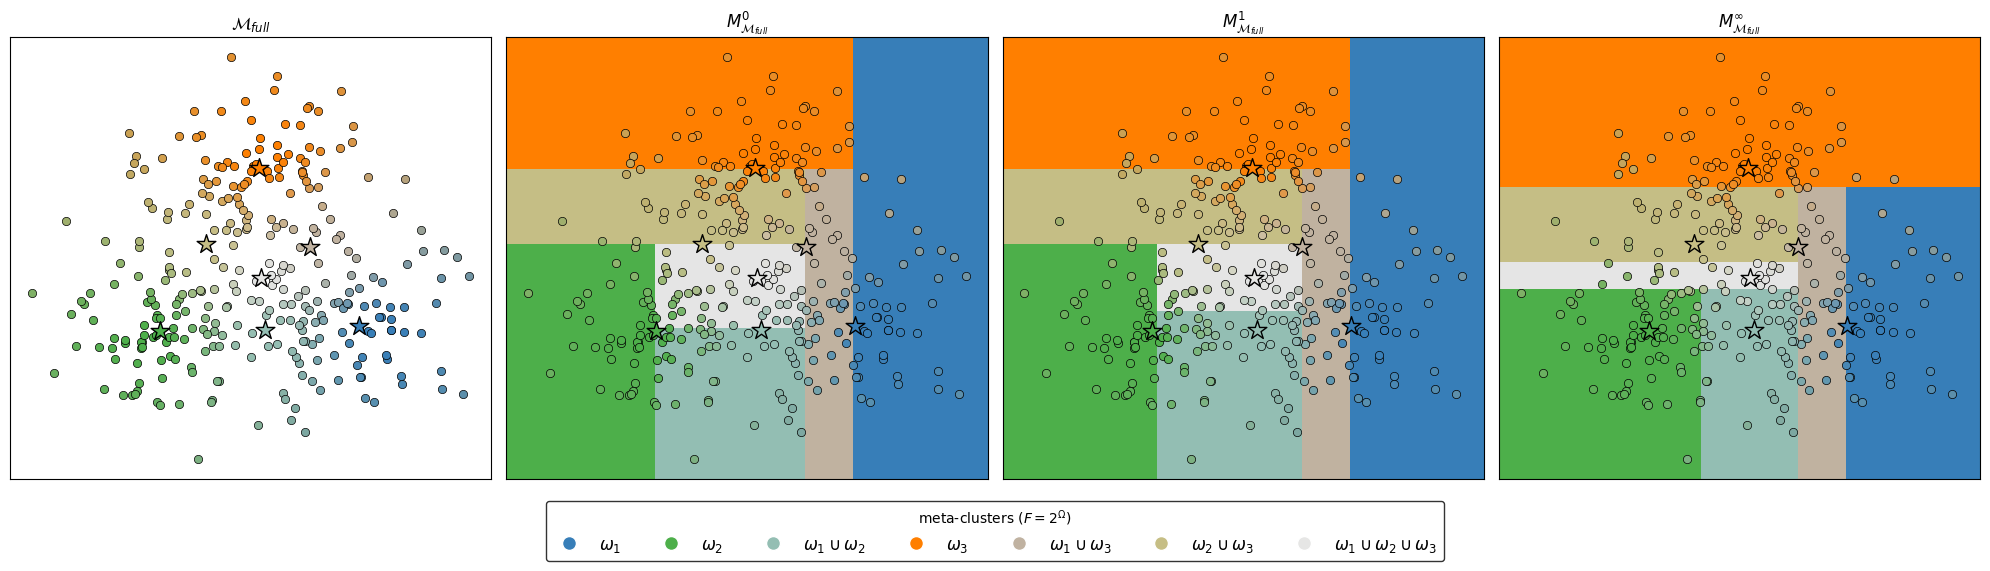

In [ ]:
number_experiments = len(masses_to_test)
if features_dimension == 2:
    fig, ax = plt.subplots(number_experiments, 4, figsize=(20, 5*len(masses_to_test)), sharex=True, sharey=True)

i = 0
comparisons = {}
scores = {}
for model_name, (mass, F, lambda_num) in masses_to_test.items():
    # test the model for different lambda values
    all_lambdas = [0, lambda_num, np.inf]

    if features_dimension == 2:
        if number_experiments == 1:
            ax_ = ax
        else:
            ax_ = ax[i, :]
    else:
        ax_ = None

    paths_df, diagrams, pred_metaclusters = explore_iemm(mass, F, model_name, all_lambdas, ax=ax_)
    i += 1

    # test imm for the model
    mass_saturated = np.zeros(mass.shape)
    max_mass = np.argmax(mass, axis=1)
    for j in range(mass.shape[0]):
        mass_saturated[j, max_mass[j]] = 1
    _, _, pred_imm = explore_iemm(mass_saturated, F, model_name + '_IMM', [np.inf])

    for treshold in np.arange(0.5, 1.0, 0.01):
        score_imm = evaluate(mass, pred_imm[np.inf], F, treshold)
        scores[f'{model_name}_IMM_{treshold}'] = score_imm
        for lambda_ in all_lambdas:
            # print('------------------------')
            # print(f'{model_name}_{lambda_}_{treshold}')
            score = evaluate(mass, pred_metaclusters[lambda_], F, treshold)
            scores[f'{model_name}_{lambda_}_{treshold}'] = score
            comparisons[f'{model_name}_{lambda_}_{treshold}'] = score/score_imm - 1

if features_dimension == 2:
    if number_experiments == 3:
        anchor = (0.5, -0.05)
    elif number_experiments == 1:
        anchor = (0.5, -0.15)
    else:
        anchor = (0.5, -0.2)

    focal_colors, focal_sets, mass_focal_sets = get_style(F, cmap=cmap)
    lgd = fig.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=focal_sets[i], markerfacecolor=focal_colors[i], markersize=10) for i in range(len(focal_sets))]
                                ,edgecolor='black', loc='lower center', ncol=len(focal_sets), fontsize='large', title='meta-clusters ($F = 2^\Omega$)', bbox_to_anchor=anchor)
    plt.tight_layout()
    
    if folder_figs is not None:
        os.makedirs(folder_figs, exist_ok=True)
        fig.savefig(f'{folder_figs}/{model_name}/points_plot.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

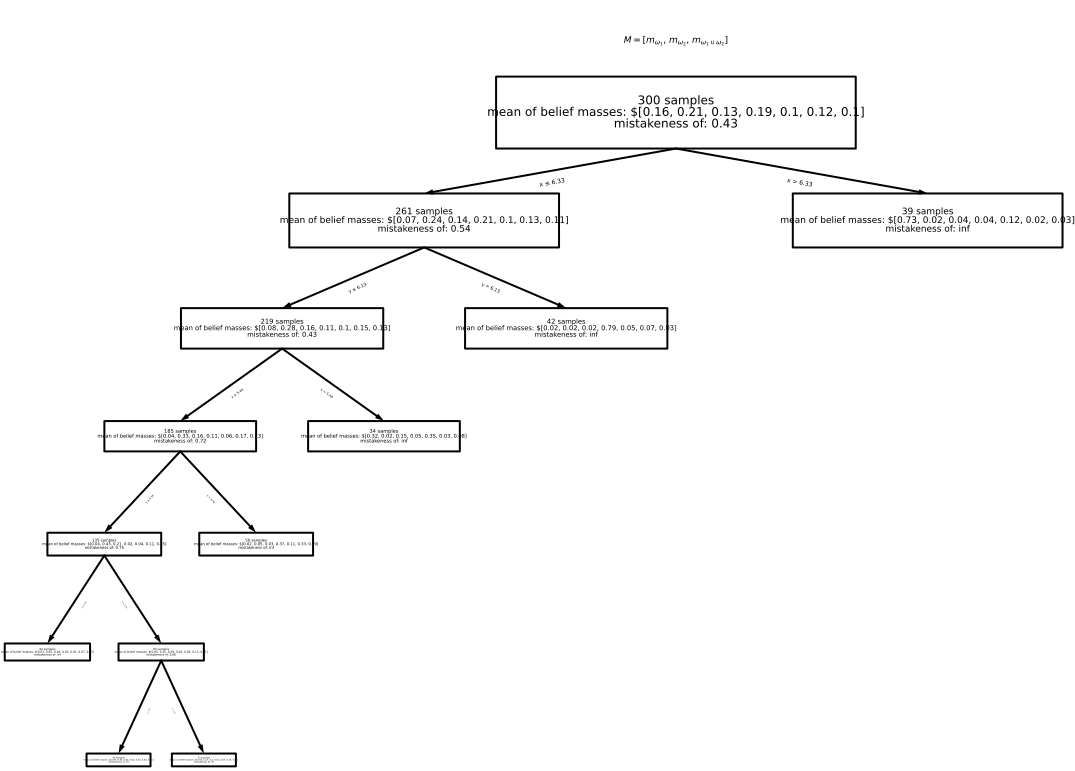

In [408]:
diagrams[0]

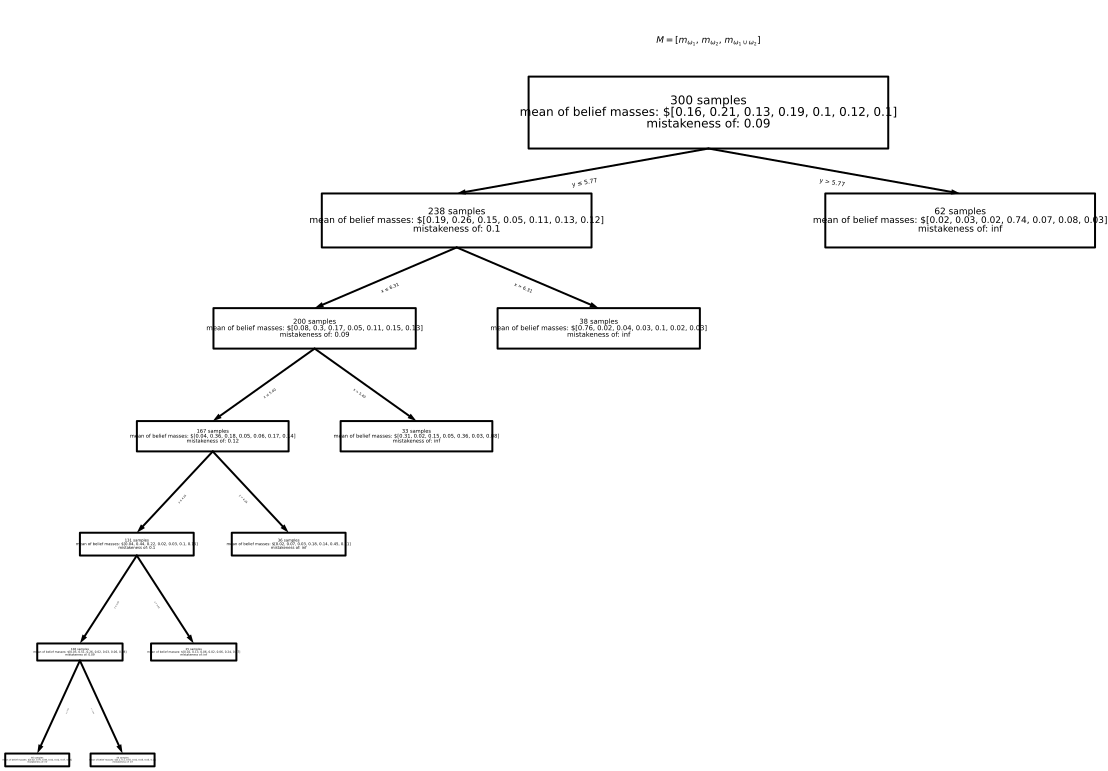

In [409]:
diagrams[np.inf]

In [410]:
scores

{'full_IMM_0.5': np.float64(0.83),
 'full_0_0.5': np.float64(0.6633333333333333),
 'full_1_0.5': np.float64(0.6966666666666667),
 'full_inf_0.5': np.float64(0.7733333333333333),
 'full_IMM_0.51': np.float64(0.8233333333333334),
 'full_0_0.51': np.float64(0.66),
 'full_1_0.51': np.float64(0.6933333333333334),
 'full_inf_0.51': np.float64(0.7633333333333333),
 'full_IMM_0.52': np.float64(0.8133333333333334),
 'full_0_0.52': np.float64(0.67),
 'full_1_0.52': np.float64(0.7033333333333334),
 'full_inf_0.52': np.float64(0.76),
 'full_IMM_0.53': np.float64(0.8133333333333334),
 'full_0_0.53': np.float64(0.6733333333333333),
 'full_1_0.53': np.float64(0.7066666666666667),
 'full_inf_0.53': np.float64(0.76),
 'full_IMM_0.54': np.float64(0.81),
 'full_0_0.54': np.float64(0.6766666666666666),
 'full_1_0.54': np.float64(0.71),
 'full_inf_0.54': np.float64(0.7566666666666667),
 'full_IMM_0.55': np.float64(0.8033333333333333),
 'full_0_0.55': np.float64(0.68),
 'full_1_0.55': np.float64(0.713333333

In [411]:
comparisons

{'full_0_0.5': np.float64(-0.20080321285140557),
 'full_1_0.5': np.float64(-0.1606425702811245),
 'full_inf_0.5': np.float64(-0.06827309236947787),
 'full_0_0.51': np.float64(-0.19838056680161942),
 'full_1_0.51': np.float64(-0.1578947368421053),
 'full_inf_0.51': np.float64(-0.07287449392712553),
 'full_0_0.52': np.float64(-0.17622950819672123),
 'full_1_0.52': np.float64(-0.13524590163934425),
 'full_inf_0.52': np.float64(-0.06557377049180324),
 'full_0_0.53': np.float64(-0.17213114754098358),
 'full_1_0.53': np.float64(-0.1311475409836066),
 'full_inf_0.53': np.float64(-0.06557377049180324),
 'full_0_0.54': np.float64(-0.16460905349794253),
 'full_1_0.54': np.float64(-0.1234567901234569),
 'full_inf_0.54': np.float64(-0.06584362139917699),
 'full_0_0.55': np.float64(-0.15352697095435675),
 'full_1_0.55': np.float64(-0.11203319502074682),
 'full_inf_0.55': np.float64(-0.053941908713692976),
 'full_0_0.56': np.float64(-0.1470588235294118),
 'full_1_0.56': np.float64(-0.105042016806722